# Who's the biggest tax evader?

#### Imports:

In [1]:
import plotly.plotly as py
import pandas as pd
import pycountry
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## 1. Data cleaning and preprocessing

### 1.1 Loading data

The goal is to better understand how different socio-economic factors are linked with tax evasion occurrences in different countries. To help us visualize this, we will use choropleth world maps to display information.

We have observed in our datasets that certain countries are referred to under different names, for instance "China" vs "People's Republic of China". Also, since we are considering data that spans over multiple years, we run into issues with countries that have changed their names, for instance Swaziland becoming Eswatini. Thus, we decided to use [ISO 3166-1](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) three-letter country codes as the identifiers for countries, as these values are consistent for all countries and through the years. From the Plotly choropleth map [documentation](https://plot.ly/python/choropleth-maps/#world-choropleth-map), we got a list of ISO country codes and country names. We choose to complete this dataset ourselves manually, when we come across new ways of writing country names. We load the dataset of country codes as a Pandas `DataFrame`:

In [2]:
# Load country codes
df_country_codes = pd.read_csv('data/countries_codes.csv', low_memory=False).set_index('COUNTRY')

We load the Panamas Papers, UN and World Bank datasets into Pandas `DataFrame`s:

In [3]:
# Load datasets
## Load panama papers datasets
pp_edges = pd.read_csv('data/panama_papers/panama_papers.edges.csv', low_memory=False)
pp_nodes_address = pd.read_csv('data/panama_papers/panama_papers.nodes.address.csv', low_memory=False)
pp_nodes_entity = pd.read_csv('data/panama_papers/panama_papers.nodes.entity.csv', low_memory=False)
pp_nodes_intermediary = pd.read_csv('data/panama_papers/panama_papers.nodes.intermediary.csv', low_memory=False)
pp_nodes_officer = pd.read_csv('data/panama_papers/panama_papers.nodes.officer.csv', low_memory=False)
## Load UN datasets
un_hdi_components_2014 = pd.read_csv('data/un/hdi_components.csv', low_memory=False)
un_gdp_per_capita = pd.read_csv('data/un/gdp_per_capita.csv', low_memory=False)
un_gdp_per_capita_ppp = pd.read_csv('data/un/gdp_per_capita_PPP.csv', low_memory=False)
## Load world bank datasets
wb_gini = pd.read_csv('data/world_bank/gini_index.csv', low_memory=False)
wb_income_share_20_per = pd.read_csv('data/world_bank/income_share_20_per.csv', low_memory=False)
wb_population_total = pd.read_csv('data/world_bank/population_total.csv', low_memory=False)

### 1.2 Examining data

We look at a few of the datasets, to see what sort of preprocessing and cleaning we will have to do.

#### UN: GDP per capita

In [4]:
un_gdp_per_capita.head()

,Country,Year,Item,Value
0,Afghanistan,2016,Gross Domestic Product (GDP),583.882867
1,Afghanistan,2015,Gross Domestic Product (GDP),610.854517
2,Afghanistan,2014,Gross Domestic Product (GDP),651.158326
3,Afghanistan,2013,Gross Domestic Product (GDP),681.033974
4,Afghanistan,2012,Gross Domestic Product (GDP),694.885886


#### UN: HDI components (2014)

In [5]:
un_hdi_components_2014.head()

,HDI rank,Country,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank
0,1,Norway,0.944,81.6,17.5,12.6,64992,5
1,2,Australia,0.935,82.4,20.2,13,42261,17
2,3,Switzerland,0.93,83,15.8,12.8,56431,6
3,4,Denmark,0.923,80.2,18.7,12.7,44025,11
4,5,Netherlands,0.922,81.6,17.9,11.9,45435,9


#### World Bank: Gini coefficient index

In [6]:
wb_gini.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### World Bank: Income share top 20%

In [7]:
wb_income_share_20_per.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,48.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,39.0,NaN,NaN,NaN,37.8,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,Income share held by highest 20%,SI.DST.05TH.20,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Panama Papers: addresses

In [8]:
pp_nodes_address.head()

,node_id,name,address,country_codes,countries,sourceID,valid_until,note
0,14000001,NaN,-\t27 ROSEWOOD DRIVE #16-19 SINGAPORE 737920,SGP,Singapore,Panama Papers,The Panama Papers data is current through 2015,NaN
1,14000002,NaN,"""Almaly Village"" v.5, Almaty Kazakhstan",KAZ,Kazakhstan,Panama Papers,The Panama Papers data is current through 2015,NaN
2,14000003,NaN,"""Cantonia"" South Road St Georges Hill Weybridg...",GBR,United Kingdom,Panama Papers,The Panama Papers data is current through 2015,NaN
3,14000004,NaN,"""CAY-OS"" NEW ROAD; ST.SAMPSON; GUERNSEY; CHANN...",GGY,Guernsey,Panama Papers,The Panama Papers data is current through 2015,NaN
4,14000005,NaN,"""Chirag"" Plot No 652; Mwamba Road; Kizingo; Mo...",KEN,Kenya,Panama Papers,The Panama Papers data is current through 2015,NaN


We see that neither of the two displayed UN datasets have a `Country Code` column. Fortunately, we are able to map `Country Name` values to their corresponding `Country Code` values. This will allow us to join `DataFrame`s later on, when performing analyses on socio-economic development factors.

We also observe that there are many NaN values in the Gini coefficient index dataset and the income share top 20% dataset. This is because these values are not measured annually in every country. We will solve this problem by taking the most recent value since 2000, for each of these datasets. This allows us to have the most accurate recent data possible.

### 1.3 Data cleaning

***Select most recent statistics:***

For the Gini coefficient index and income share top 20% datasets, we are going to take the most recent value since 2000.

In [9]:
# We only consider statistics that date from 2000 onwards
years_to_drop = list(map(str, np.arange(1960, 2000)))
wb_gini = wb_gini.drop(columns=years_to_drop)
wb_income_share_20_per = wb_income_share_20_per.drop(columns=years_to_drop)

In [10]:
# We select the rightmost value (most recent) for each row
gini_values = wb_gini.stack().groupby(level=0).last().reindex(wb_gini.index)

# Only select valid values and label other values as NaN
wb_gini['Gini'] = pd.to_numeric(gini_values, errors='coerce')

# Only select relevant columns
wb_gini = wb_gini[['Country Name', 'Country Code', 'Gini']]

In [11]:
# We select the rightmost value (most recent) for each row
income_share_20_per_values = wb_income_share_20_per.stack().groupby(level=0).last().reindex(wb_income_share_20_per.index)

# Only select valid values and label other values as NaN
wb_income_share_20_per['Income Share'] = pd.to_numeric(income_share_20_per_values, errors='coerce')

# Only select relevant columns
wb_income_share_20_per = wb_income_share_20_per[['Country Name', 'Country Code', 'Income Share']]

***Add country codes to UN datasets:***

In order to display the values on maps, we need the UN datasets to contain country codes. We will perform a join on each of the UN datasets with the country codes dataset, `df_country_codes`. We will attempt to automate this process, before considering any exceptions:

In [12]:
# Join UN datasets with country codes DataFrame
un_hdi_components_2014 = un_hdi_components_2014.join(df_country_codes, on='Country')
un_gdp_per_capita = un_gdp_per_capita.join(df_country_codes, on='Country')
un_gdp_per_capita_ppp = un_gdp_per_capita_ppp.join(df_country_codes, on='Country')

We remove any parts of a country name that contain parentheses, for instance "Iran (Islamic Republic of)" becomes "Iran":

In [13]:
# List of UN DataFrames
un_dfs = [un_hdi_components_2014, un_gdp_per_capita, un_gdp_per_capita_ppp]

# Define dictionary containing pairs (country name: ISO country code)
countries = dict()

for country in pycountry.countries:
    countries[country.name] = country.alpha_3  

for df in un_dfs:
    nan_values = df['CODE'].isna()
    input_countries = list(df[nan_values]['Country'].values)
        
    codes = []
    for country in input_countries:
        if country in countries:
            codes.append(countries.get(country))
        else:        
            accepted = []
            str_country = str(country)
            # check if string contains either common or official country name
            for p_country in pycountry.countries:
                if p_country.name in str_country or (hasattr(p_country, 'common_name') and p_country.common_name in str_country):
                    accepted.append(p_country.alpha_3)
            if len(accepted) == 1:
                codes.append(accepted[0])
            else:
                codes.append(None)

    df.loc[nan_values, 'CODE'] = codes
    # Remove rows that were not found
    df = df[df['CODE'].notnull()]

### 1.4 Data processing

***Number of Panama Papers references per country:***

Since one of our major interests is to study the distribution of Panama Papers references per country, we create a dataset containing country codes and the number of occurrences of that country in the `pp_nodes_address` dataset, which contains the addresses of entities, officers and intermediaries.

In [24]:
pp_references_country = pp_nodes_address.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_references_country.head()

,country_codes,countries,counts
0,ABW,Aruba,18
1,AGO,Angola,38
2,AIA,Anguilla,105
3,ALB,Albania,23
4,AND,Andorra,35


***Number of Panama Papers references with respect to population size:***

Knowing the number of appearances of each country in the addresses leaked in Panama Papers is not very useful; some countries have a much bigger population and will therefore be over-represented. We normalize the number of occurrences using the following formula:
$$ count_{1000} = \frac{nb \, occurrences}{population_{2014}} $$

In [15]:
wb_population_2014 = wb_population_total[['Country Code', '2014']]
occurrence_pop = pp_references_country.merge(wb_population_2014, left_on='country_codes', right_on='Country Code')
occurrence_pop['counts_1000'] = 1000 * occurrence_pop['counts'] / occurrence_pop['2014']

## 2. Data analysis and observations

### 2.1 Panama Papers and population

First, we study the distribution of the number of Panama Papers references in each country per 1000 inhabitants, to get a better idea of what kind of data we are dealing with.

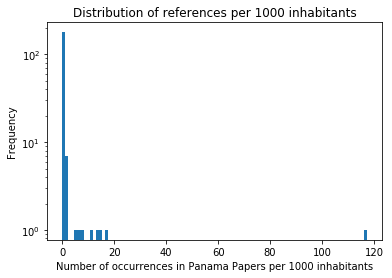

In [16]:
occurrence_pop['counts_1000'].plot.hist(title='Distribution of references per 1000 inhabitants', bins=100, logy=True)
plt.xlabel('Number of occurrences in Panama Papers per 1000 inhabitants')
plt.show()

We also want to see the countries with the highest occurrence to population ratio:

In [17]:
occurrence_pop.sort_values('counts_1000', ascending=False).head(10)

,country_codes,countries,counts,Country Code,2014,counts_1000
185,VGB,British Virgin Islands,3467,VGB,29588.0,117.175882
101,LIE,Liechtenstein,635,LIE,37127.0,17.103456
109,MCO,Monaco,538,MCO,38132.0,14.108885
78,IMN,Isle of Man,1144,IMN,82590.0,13.851556
62,GIB,Gibraltar,393,GIB,34038.0,11.545919
166,SYC,Seychelles,733,SYC,91359.0,8.023293
41,CYM,Cayman Islands,389,CYM,59172.0,6.574055
93,KNA,Saint Kitts and Nevis,292,KNA,53739.0,5.433670
22,BMU,Bermuda,150,BMU,65139.0,2.302768
18,BHS,Bahamas,842,BHS,382169.0,2.203214


We observe that a large majority of countries are almost not cited in Panama Papers (relative to the population size). The rest of the countries have fewer than 20 references per 1000 in habitants, and there is one extreme outlier with 115 references per 1000 inhabitants. This odd distribution is probably due to the fact that most of the addresses we used belong to mirror companies and not to individuals. Since most of the companies are established in fiscal paradises, only a few countries have a relevant ` nb occurrences / population` ratio.

Thus, this does not seem like an appropriate metric to study where the tax evaders in Panama Papers come from.

We'll try to further analyze the data by only using the addresses of intermediaries linked to the Panama Papers.

### 2.2 Panama Papers intermediaries

Now, we want to study the distribution of intermediaries in Panama Papers around the world. We do so by only considering the addresses of the intermediaries in the `pp_nodes_intermediary` dataset:

In [18]:
pp_intermediary_country = pp_nodes_intermediary.groupby(['country_codes', 'countries']).size().reset_index(name='counts')
pp_intermediary_country = pp_intermediary_country.sort_values('counts', ascending=False)
pp_intermediary_country.head()

,country_codes,countries,counts
91,HKG,Hong Kong,2202
75,GBR,United Kingdom,1367
28,CHE,Switzerland,1218
217,USA,United States,603
161,PAN,Panama,552


We display the distribution using a map:

In [19]:
data = [ dict(
        type = 'choropleth',
        locations = pp_intermediary_country['country_codes'],
        z = pp_intermediary_country['counts'],
        text = pp_intermediary_country['countries'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of references'),
      ) ]

layout = dict(
    title = 'References in Panama Papers',
    geo = dict(
        showcountries = True,
        countrycolor = "rgb(217, 217, 217)",
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        ),
        bgcolor = 'rgba(255, 255, 255, 0.0)',
    )
)

fig = dict( data=data, layout=layout )

iplot( fig, validate=False)

We know that the intermediaries dataset contains the list of lawyers and accountants involved in the account set up. Counting them by country paints a much different picture from what we had so far.

In section 2.1, when we considered the total distribution of occurrences with respect to population size, we saw a combination of small countries, generally perceived to be tax havens, as well as mostly rich countries. This was somewhat expected, as the money is being sent from those rich countries into the tax havens.

By counting the intermediaries, we see that the vast majority come from more rich and developed countries. We particularly see a very large number of people from Switzerland, Panama and the UK (as well as other British tax havens), suggesting that these countries were heavily involved in this affair. This matches the reports from the media, such as [this](https://www.theguardian.com/news/2016/apr/08/mossack-fonseca-law-firm-hide-money-panama-papers).

## 3. Next steps

We can see from the tables that most of the countries involved in the Panama Papers affair are small islands, which unfortunately are not displayed by the `Plotly` library. For the next milestone, we will fix that issue either by finding a solution that still works with `Plotly` or by using a different library, such as `folium`.

So far, we have made insightful observations that match the reports found in the media, particularly about which countries were most involved in this affair.

For the next milestone, we will further investigate the links between the countries, and try to understand the correlation of socio-economic factors with the locations of entities, officers and intermediaries involved in Panama Papers. More specifically, we intend to:
- Find which socio-economic factors are correlated with the results we found so far, and how they are correlated
- Display the links between the countries using a graph similar to the one found [here](https://plot.ly/python/lines-on-maps/)
- Fix issues with certain countries (particularly small islands) not being displayed in the graph
-